# Exercise 8.4

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(0)

In [2]:
class ShortcutMaze():
	def __init__(self, height, width, wall, start, goal):
		self.height = height
		self.width = width
		self.wall = wall
		self.start = start
		self.goal = goal

		self.shortcut_open = False

	def setShortcut(self, shortcut_open):
		self.shortcut_open = shortcut_open
		print(f"Shortcut is now {'open' if shortcut_open else 'closed'}")

	def reset(self):
		return self.start

	def getActions(self, state):
		return [(0, 1), (0, -1), (1, 0), (-1, 0)]

	def transition(self, state, action):
		# Returns: next_state, reward, terminal
		x, y = state
		new_x, new_y = x + action[0], y + action[1]
		
		if new_x < 0 or new_x >= self.width or new_y < 0 or new_y >= self.height:
			return (x, y), 0, False
		if new_y == self.wall:
			
			if new_x == 0:
				return (new_x, new_y), 0, False
			elif self.shortcut_open and new_x == self.width - 1:
				return (new_x, new_y), 0, False
			else:
				return (x, y), 0, False

		if new_x == self.goal[0] and new_y == self.goal[1]:
			return (new_x, new_y), 1, True			

		return (new_x, new_y), 0, False

In [3]:
class DynaQAgent:
	def __init__(self, maze, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning_steps=50):
		self.maze = maze
		self.alpha = alpha  # Learning rate
		self.gamma = gamma  # Discount factor
		self.epsilon = epsilon  # Exploration rate
		self.n_planning_steps = n_planning_steps  # Number of planning steps

		self.Q = {}  # Q-value table
		self.Model = {}  # Model of the environment
		self.observed_states = set()
		self.observed_actions = {}  # Actions taken in each state
		self.state_action_last_observed = {}  # Last time a state-action pair was observed
		self.time = 0

	def choose_action(self, state):
		actions = self.maze.getActions(state)
		if random.uniform(0, 1) < self.epsilon:
			return random.choice(actions)
		else:
			# Choose action with maximum Q(s, a)
			max_q = float('-inf')
			best_actions = []
			for action in actions:
				q_value = self.Q.get((state, action), 0)
				if q_value > max_q:
					max_q = q_value
					best_actions = [action]
				elif q_value == max_q:
					best_actions.append(action)
			return random.choice(best_actions)

	def update_q_value(self, state, action, reward, next_state, terminal):
		if terminal:
			target = reward
		else:
			next_actions = self.maze.getActions(next_state)
			max_q_next = max([self.Q.get((next_state, a), 0) for a in next_actions])
			target = reward + self.gamma * max_q_next

		current_q = self.Q.get((state, action), 0)
		self.Q[(state, action)] = current_q + self.alpha * (target - current_q)

	def planning_step(self):
		for _ in range(self.n_planning_steps):
			state = random.choice(list(self.observed_states))
			action = random.choice(list(self.observed_actions[state]))
			reward, next_state = self.Model[(state, action)]

			terminal = next_state == self.maze.goal
			self.update_q_value(state, action, reward, next_state, terminal)

	def learn(self, num_timesteps, shortcut_open_timestep):
		cummulative_rewards = [0]
		self.maze.setShortcut(False)
		while True:
			state = self.maze.reset()
			terminal = False
			steps = 0

			while not terminal:
				if self.time == shortcut_open_timestep:
					self.maze.setShortcut(True)
				steps += 1
				action = self.choose_action(state)
				next_state, reward, terminal = self.maze.transition(state, action)

				# Update Q-value and Model
				self.update_q_value(state, action, reward, next_state, terminal)
				self.Model[(state, action)] = (reward, next_state)

				# Record observed states and actions
				self.observed_states.add(state)
				if state not in self.observed_actions:
					self.observed_actions[state] = set()
				self.observed_actions[state].add(action)
				self.state_action_last_observed[(state, action)] = self.time
				# Planning steps
				self.planning_step()

				state = next_state
				self.time += 1
				cummulative_rewards.append(cummulative_rewards[-1] + reward)
				if self.time == num_timesteps:
					return cummulative_rewards



In [4]:
class DynaQPlusAgent(DynaQAgent):
	def __init__(self, maze, alpha=0.2, gamma=0.95, epsilon=0.1, n_planning_steps=50, kappa=0.001):
		super().__init__(maze, alpha, gamma, epsilon, n_planning_steps)
		self.kappa = kappa
	
	def planning_step(self):
		for _ in range(self.n_planning_steps):
			state = random.choice(list(self.observed_states))
			action = random.choice(list(self.observed_actions[state]))
			reward, next_state = self.Model[(state, action)]

			new_reward = reward + self.kappa * np.sqrt(self.time - self.state_action_last_observed.get((state, action), 0))
			terminal = next_state == self.maze.goal
			self.update_q_value(state, action, new_reward, next_state, terminal)
	
class NewDynaQPlusAgent(DynaQAgent):
	def __init__(self, maze, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning_steps=50, kappa=0.001):
		super().__init__(maze, alpha, gamma, epsilon, n_planning_steps)
		self.kappa = kappa
	
	def choose_action(self, state):
		actions = self.maze.getActions(state)
		if random.uniform(0, 1) < self.epsilon:
			return random.choice(actions)
		else:
			# Choose action with maximum Q(s, a)
			max_q = float('-inf')
			best_actions = []
			for action in actions:
				q_value = self.Q.get((state, action), 0) + self.kappa * np.sqrt(self.time - self.state_action_last_observed.get((state, action), 0))
				if q_value > max_q:
					max_q = q_value
					best_actions = [action]
				elif q_value == max_q:
					best_actions.append(action)
			return random.choice(best_actions)
	



Shortcut is now closed
Shortcut is now open
Shortcut is now closed
Shortcut is now open
Shortcut is now closed
Shortcut is now open


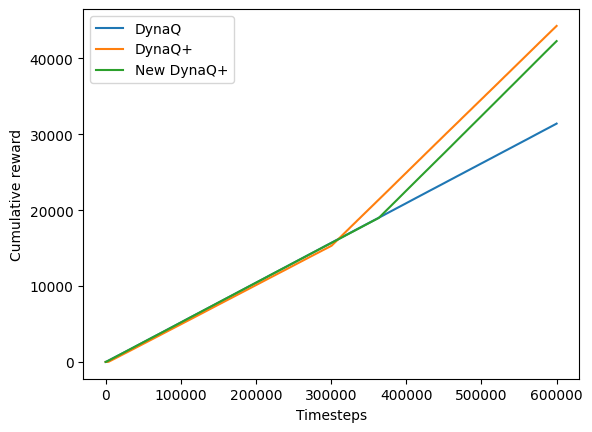

In [5]:
maze = ShortcutMaze(6, 9, 2, (4, 0), (8, 5))

dynaQAgent = DynaQAgent(maze, alpha=0.5, gamma=0.95, epsilon=0.1, n_planning_steps=20)
dynaQPlusAgent = DynaQPlusAgent(maze, alpha=0.5, gamma=0.95, epsilon=0.1, n_planning_steps=20, kappa=0.0005)
newDynaQPlusAgent = NewDynaQPlusAgent(maze, alpha=0.5, gamma=0.95, epsilon=0.1, n_planning_steps=20, kappa=0.0005)

num_timesteps = 600000
shortcut_open = 300000
cum_rew_dynaQ = dynaQAgent.learn(num_timesteps, shortcut_open)
cum_rew_dynaQPlus = dynaQPlusAgent.learn(num_timesteps, shortcut_open)
cum_rew_newDynaQPlus = newDynaQPlusAgent.learn(num_timesteps, shortcut_open)

plt.plot(cum_rew_dynaQ, label='DynaQ')
plt.plot(cum_rew_dynaQPlus, label='DynaQ+')
plt.plot(cum_rew_newDynaQPlus, label='New DynaQ+')
plt.xlabel('Timesteps')
plt.ylabel('Cumulative reward')
plt.legend()
plt.savefig("../chapters_latex/figures/ex_08_04.pdf")
plt.show()